**NOMS I COGNOMS:** 

**GRUP DE LABORATORI:** 

# Anàlisi exploratòria de dades i preprocessament 

L'**anàlisi exploratòria de dades** és el tractament estadístic al qual se sotmeten les mostres recollides durant un procés de recerca en qualsevol camp científic. 
Per a major rapidesa i precisió, tot el procés sol realitzar-se per mitjans informàtics, amb aplicacions específiques per al tractament estadístic.

### Aplicació a la Mineria de Dades

A la **mineria de dades**, si bé no és obligatori, és una bona pràctica analitzar les dades amb què treballarem per tal d'observar-ne les característiques principals per tal de tenir una idea de l'estructura del conjunt de dades, identificar la variable objectiu i possibles tècniques de modelatge.

**Procés bàsic**
- *Transformar les dades*: Ens serveix per saber què fer front a valors nuls, faltants o dades atípiques. A més destablir si hi ha necessitat de reduir la dimensionalitat de dades.
- *Visualitzar*: Utilitzar alguna eina per fer una representació gràfica de les dades, per exemple, R, Jupyter notebook, Google Colab, etc.
- *Analitzar i interpretar*: Analitzar i interpretar les dades a través de diferents visualitzacions.
- *Documentar*: Documentar totes les gràfiques i estadístiques generades.

Aquest procés ens és útil també en revisar la descripció de les dades per comprendre què significa cada característica.

Hi ha diverses activitats en fer una anàlisi exploratòria de dades però quant a la mineria de dades els punts clau que s'han de realitzar són:

- Descripció de l'estructura de les dades.
- Identificació de dades mancants.# ¿Com ha afectat la covid a l'ús dels taxis a Nova York? 
- Detecció de valors atípics.
- Identificació de relacions entre parells variables.

Si realitzem correctament els passos ens facilitarem la manera d'abordar aquestes dades sense deixar de banda l'objectiu o el propòsit per al qual les necessitem.

L'**objectiu d'aquesta pràctica** és aprendre com fer una explicació de dades. En aquest cas utilitzarem les dades dels **taxis grocs de la ciutat de Nova York**.

En finalitzar el notebook, haureu de ser capaços de respondre la pregunta següent:


## ¿Com ha afectat la covid a l'ús dels taxis a Nova York? 

Algunes de les preguntes que ens farem al llarg del notebook són:
- Com ha canviat la covid l'ús dels taxis a NYC?
- Quina distribució d'encàrrecs segueixen els taxis i quina distància / durada tenen?
- Quines són les zones on m'és / menys taxis s'agafen? I a on més va la gent?
- Quins horaris són els més usuals?
- Quins dies de la setmana i del mes s'utilitzen més? Possibles motius?

**Instal·lació i importació de les llibreries necessàries**

In [96]:
import pandas as pd
import numpy as np
import urllib.request
import zipfile
import os
from tqdm.notebook import tqdm
import pyarrow.parquet as pq

In [97]:
import shapefile
from shapely.geometry import Polygon
from descartes.patch import PolygonPatch
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

In [98]:
YEARS = [2019, 2020, 2021]
COLORS = ['palevioletred','lightskyblue','gold']
required_data = ['tpep_pickup_datetime', 'tpep_dropoff_datetime', 'passenger_count', 'trip_distance', 'PULocationID', 'DOLocationID', 'payment_type', 'fare_amount', 'total_amount']

Primer de tot cal descarregar les dades:

https://www1.nyc.gov/site/tlc/about/tlc-trip-record-data.page

In [99]:
# Download the Trip Record Data
for year in tqdm(YEARS):
    if not os.path.exists(f'data/{year}'):
        os.makedirs(f'data/{year}', exist_ok=True)
        for month in tqdm(range(1, 13)): 
            urllib.request.urlretrieve(f'https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_{year}-{month:02d}.parquet', f'data/{year}/{month:02d}.parquet')

  0%|          | 0/3 [00:00<?, ?it/s]

## 01. Neteja de dades

Per tal de tenir unes dades netes i útils, cal eliminar totes aquelles files que continguin informació corrupta:
- La recollida és després que la finalització del trajecte.
- Les dades s'importen per mes i any. Les dates són correctes?
- Viatges amb 0 passatges?
- Viatges molts llargs o molt curts?
- Pagaments negatius.

**Data Dictionary**

De totes les columnes que tenen les dades, només calen les següents:

- *tpep_pickup_datetime*: The date and time when the meter was engaged.
- *tpep_dropoff_datetime*: The date and time when the meter was disengaged. 
- *Passenger_count*: The number of passengers in the vehicle. (This is a driver-entered value)
- *Trip_distance*: The elapsed trip distance in miles reported by the taximeter.
- *PULocationID*: TLC Taxi Zone in which the taximeter was engaged
- *DOLocationID*: TLC Taxi Zone in which the taximeter was disengaged
- *Payment_type*: A numeric code signifying how the passenger paid for the trip. 
    - 1= Credit card
    - 2= Cash
    - 3= No charge
    - 4= Dispute
    - 5= Unknown
    - 6= Voided trip
- *Fare_amount*: The time-and-distance fare calculated by the meter.
- *Total_amount*: The total amount charged to passengers. Does not include cash tips.

**Observacions:**

- Per agilitzar els càlculs i reduir el temps de còmput, feu un sampleig uniforme de les dades.
- Datatime columns són to_datetime series (ajuda per buscar les funcions)

In [100]:
def load_table(year, month):
    """
    Funció que llegeix les dades descarregades i les converteix a un DataFrame
    """
    return pq.read_table(f'data/{year}/{str(month).zfill(2)}.parquet').to_pandas()

In [101]:
def clean_data(data, year, month, sampling = 1000):
    """
    Funció que neteja les dades per un mes donat.
    """
    # Eliminem totes aquelles files que continguin informació corrupta:

    # només agafarem les columnes necessàries
    netejada = data[required_data]
    
    if sampling != 0:
        netejada = netejada[::sampling]

    # La recollida és després que la finalització del trajecte.
    netejada = netejada[netejada['tpep_dropoff_datetime'] > netejada['tpep_pickup_datetime']]
    #netejada = netejada[netejada['tpep_dropoff_datetime'] < netejada['tpep_pickup_datetime']]

    # Les dades s'importen per mes i any. Les dates són correctes?
    # type -> netejada['tpep_pickup_datetime'][0] -> pandas._libs.tslibs.timestamps.Timestamp'
    # extreurem el mes i l'any amb la comanda -> pd.DatetimeIndex(df['birth_date']).year /  pd.DatetimeIndex(df['birth_date']).month
    anyCorrecte_pick = pd.DatetimeIndex(netejada['tpep_pickup_datetime']).year == year
    mesCorrecte_pick = pd.DatetimeIndex(netejada['tpep_pickup_datetime']).month == month
    anyCorrecte_drop = pd.DatetimeIndex(netejada['tpep_dropoff_datetime']).year == year
    mesCorrecte_drop = pd.DatetimeIndex(netejada['tpep_dropoff_datetime']).month == month
    netejada = netejada[(anyCorrecte_pick & mesCorrecte_pick) & (anyCorrecte_drop & mesCorrecte_drop)]

    # eliminar els de amb 0 passatgers
    condicio = netejada['passenger_count'] > 0
    condicio2 = netejada['passenger_count'] <= 9
    netejada = netejada[condicio & condicio2]

    # Viatges molts llargs o molt curts
    viatges_valids = netejada['trip_distance'] > 0
    viatges_no_llargs = netejada['trip_distance'] < 100
    netejada = netejada[viatges_valids & viatges_no_llargs]

    # pagaments negatius
    pagats = netejada['total_amount'] > 0
    netejada = netejada[pagats]
    
    netejada.drop_duplicates()
    return netejada

A la funció *post_processing* podeu afegir tota aquesta informació que necessiteu sobre les dades per tal de dur a terme l'exploració necessària.

In [102]:
def post_processing(data):
    """
    Funció on implementar qualsevol tipus de postprocessament necessari.
    """
    data = data[required_data]
    # podem afegir columnes que indiquin l'any, el mes i el dia que s'ha realitzat el viatge
    data['year'] = pd.DatetimeIndex(data['tpep_pickup_datetime']).year
    return data

Crea un nou dataset que contingui tota la informació dels anys: 2019, 2020, 2021.

Recordeu que per tal de reduir la memòria necessària, podeu agafar un subsample de dades.

In [103]:
df = pd.concat([clean_data(load_table(year, month), year, month,1000) for year in tqdm(YEARS) for month in tqdm(range(1, 13), leave = False)])

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

In [104]:
df = post_processing(df)
df.shape

(132842, 10)

In [105]:
df.head(1)

,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,PULocationID,DOLocationID,payment_type,fare_amount,total_amount,year
0,2019-01-01 00:46:40,2019-01-01 00:53:20,1.0,1.5,151,239,1,7.0,9.95,2019


# NO TOCAR DF FORA DE LES FUNCIONS!!

## 02. Visualitzacions per anys

### Número total sobre quantitat de viatges

Podem respondre directament la pregunta: **¿Ha incrementat / disminuït la covid la quantitat de viatges fets amb taxis?**

Per respondre aquesta pregunta creu una figura de barres on es visualitzin la quantitat de viatges per any.

In [106]:
def bar_plot(df, column, xlabel, ylabel, title):
    """
    Funció que crea una figura de barres a partir del dataframe i la columna que conté la informació
    """
    nova = df.groupby(column).count()
    
    # només agafarem una columna qualsevol
    nova = nova['tpep_pickup_datetime']
    nova.plot(kind = 'bar', color = 'pink')
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)

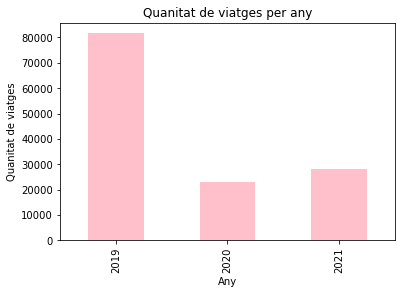

In [107]:
bar_plot(df, 'year', 'Any', 'Quanitat de viatges', 'Quanitat de viatges per any')

In [108]:
# Podrem veure que la quantitat de viatges en taxis a l'any 2020 ha reduït de forma notòria respecte els altres anys, sent la quantitat de
# viatges realitzades en taxi als 3 anys:
# 2019    81724960
# 2020    22946824
# 2021    28244722

**Pregunta: És el comportament que esperàveu? Per què?**

> ANSWER: Sí. Podem veure a partir del diagram de barres, que els viatges realitzats a l'any 2020, i 2021 va disminuir molt comparant amb els de l'any 2019, de manera que podem  confirmar que la pandèmia va afectar a la quantitat de viatges fets amb taxis.

Ara, visualitzarem **quants passatgers hi ha per taxi i per any**.

Crea una figura amb tres subfigures (una per any) on es pugui veure el recompte de passatgers per any.

Després repetiu el mateix gràfic visualitzant el % (utilitzeu el paràmetre *norm*).

In [109]:
def bars_plot(bars, column, xlabel, ylabel, title, ylim, norm):
    """
    Funció que crea diverses figures de barres a partir del dataframe i la columna que conté la informació
    """
    figure = plt.figure(figsize=(15,15))
    
    for index,year in enumerate(bars):
        # obtenim la serie que conte el nombre de viatges segons el nombre de passatgers
        serie = year.groupby(column).size()
        
        if norm:
            #obtenim la mitja
            suma = year[column].sum()
            #modifiquem la serie
            serie = serie/suma

        # mostrem el diagrama de barres
        figure.add_subplot(1,3,(index+1))
        serie.plot(kind = 'bar', color = COLORS[index])
        plt.xlabel(xlabel)
        plt.ylabel(ylabel)
        plt.title(title + ' ' + str(YEARS[index]))
        plt.ylim(ylim)

In [110]:
def passengers_taxi_year(df, ylim, xlabel, ylabel, title, norm = False):
    """
    Funció que visualitza quants passatgers hi ha per taxi i per any
        df : data Frame
        ylim: rang dels valors de l'eix y
        xlabel: titol eix x
        ylabel: titol eix y
    """
    bars = []
    for index,year in enumerate(YEARS):
        # obtenir les files de l'any corresponent
        condicio = df['year'] == year
        taula_any = df.loc[condicio]
        bars.append(taula_any)
        
    # mostrem els diagrames de barres
    bars_plot(bars, 'passenger_count', xlabel, ylabel, title, ylim, norm)

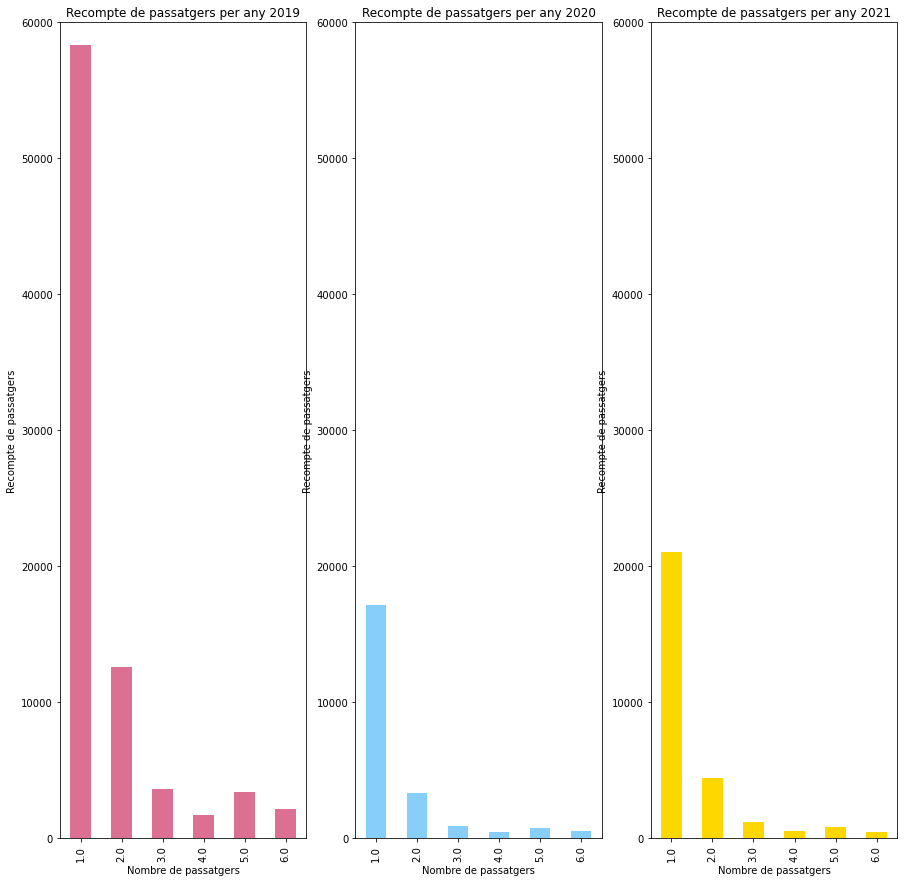

In [111]:
passengers_taxi_year(df, (0, 60000), 'Nombre de passatgers', 'Recompte de passatgers', 'Recompte de passatgers per any')
# NOTA: el paràmetre original per posar límits a l'eix y era: (0,60000), com que hem fet sampleig de dades, l'hem posada a 6000

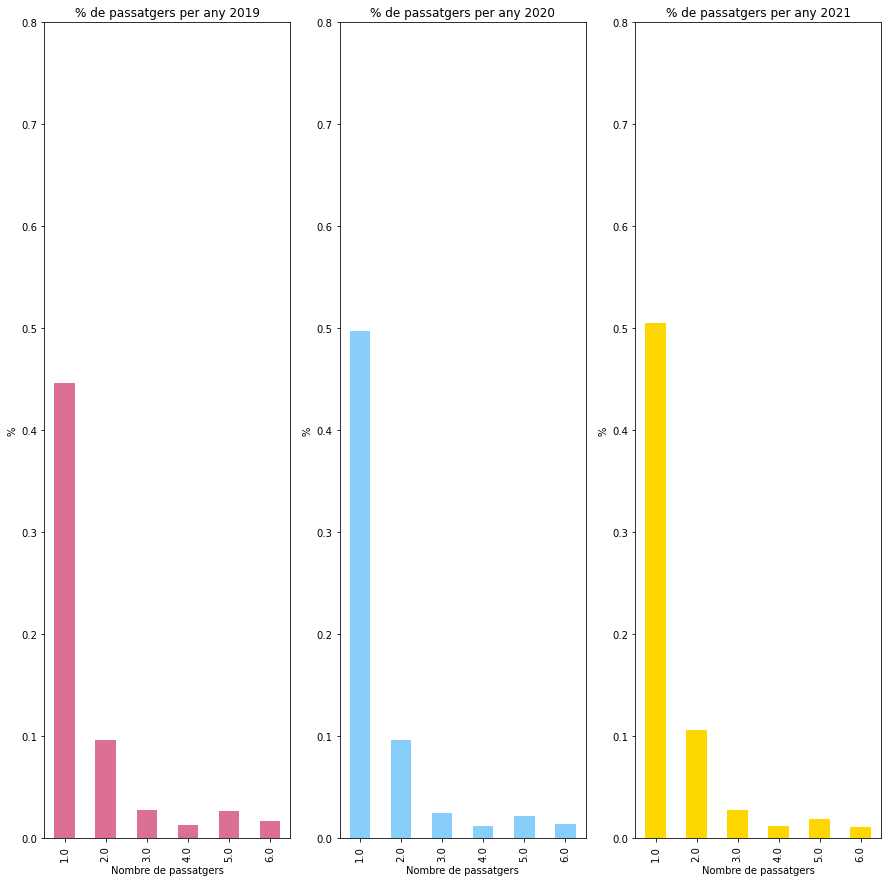

In [112]:
passengers_taxi_year(df, (0, 0.8), 'Nombre de passatgers', '%', '% de passatgers per any', norm = True)

A la figura anterior hem visualitzat cada any per separat. Per tal que la visualització sigui més ràpida i simple d'interpretar, uniu tota la informació en un gràfic.

Després repetiu el mateix gràfic visualitzant el % (utilitzeu el paràmetre *norm*).

In [113]:
def plot_grouped_bars(bars,xlabel,ylabel):
    """
    Funció que mostra el diagrama de conjunts de barres
    """
    barWidth = 0.25
    positions = []
    pos = np.arange(len(bars[0]))
    
    # noms en l'eix x
    xstick = [x + 1 for x in pos]
    
    # configurem les posicions de les barres en l'eix X per les diferents barres que tenim
    for i in range(len(bars)):
        if i == 0:
            positions.append(pos)
        pos = [x + barWidth for x in pos]
        positions.append(pos)
    
    # construim el diagrama
    for index,bar in enumerate(bars):
        plt.bar(positions[index], bar, color = COLORS[index], width=barWidth, edgecolor='white', label=str(YEARS[index]))
        
        # titol de l'exi x
        plt.xlabel(xlabel, fontweight='bold')
        # posem noms a l'eix x
        plt.xticks([r + barWidth for r in range(len(bar))], xstick)
        # titol de l'eix y
        plt.ylabel(ylabel)
        plt.legend()

In [114]:
def passengers_taxi(df, xlabel, ylabel, norm = False):
    """
    Funció que visualitza quants passatgers hi ha per taxi
    """
    bars = []
    for index,year in enumerate(YEARS):
        # obtenir les files de l'any corresponent
        condicio = df['year'] == year
        taula_any = df.loc[condicio]
        
        # obtenim la serie del nombre de viatges segons el nombre de passatgers que hi ha en un taxi
        serie = taula_any.groupby('passenger_count').size()
        if norm:
            suma = taula_any['passenger_count'].sum()
            serie = serie/suma
        bars.append(serie)
        
    # mostrem els diagrames de barres
    plot_grouped_bars(bars,xlabel,ylabel)

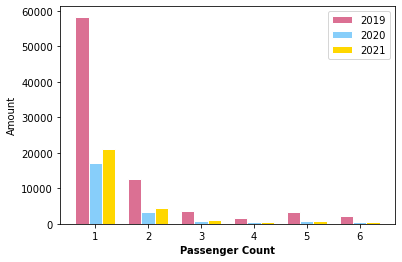

In [115]:
passengers_taxi(df, 'Passenger Count', 'Amount')

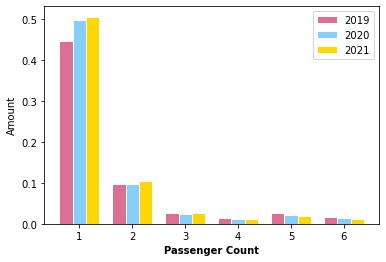

In [116]:
passengers_taxi(df, 'Passenger Count', 'Amount', norm = True)

**Pregunta: Quin impacte heu vist sobre les dades? Creieu que la covid va tenir molt impacte?**

> ANSWER : Podem vuere que els viatges que s'han realitzat durant el període de la pandèmia ha disminuït de forma notòria respecte els altres anys. I el 2021 ha tornat a augmentar. A apart d'això, podem veure que a causa de l'implantació de les restriccions sanitàries, el percentatge d'anar només 1 passatger al taxi és molt més alt en els anys 2020 i 2021.

## 03. Quantitat de viatges

Fins ara hem vist la quantitat de viatges que hi ha hagut en els anys estudiats.

Anem a estudiar quins canvis es poden veure si agreguem les dades per hores, dies de la setmana, setmana de l'any i mes.

Aquests gràfics han de ser de línies discontínues i marcar amb una rodona o creu allà on està el valor

In [117]:
def visualize_trips(columns, title, xlabel, ylabel):
    """
    Funció que visualitza els viatges per diferents agregacions de dades
    """
    dades = []
    # obtenim les dades corresponents pels diferents casos
    # recompte segons hores
    if columns[0] == 'pickup_hour':
        pick = pd.DatetimeIndex(df['tpep_pickup_datetime']).hour
        drop = pd.DatetimeIndex(df['tpep_dropoff_datetime']).hour
        
    # recompte segons dia
    elif columns[0] == 'pickup_day':
        pick = pd.DatetimeIndex(df['tpep_pickup_datetime']).dayofweek
        drop = pd.DatetimeIndex(df['tpep_dropoff_datetime']).dayofweek

    # recompte segons setmana
    elif columns[0] == 'pickup_week':
        pick = pd.Int64Index(pd.DatetimeIndex(df['tpep_pickup_datetime']).isocalendar().week)
        drop = pd.Int64Index(pd.DatetimeIndex(df['tpep_dropoff_datetime']).isocalendar().week)

    # recompte segons mesos
    elif columns[0] == 'pickup_month':
        pick = pd.DatetimeIndex(df['tpep_pickup_datetime']).month
        drop = pd.DatetimeIndex(df['tpep_dropoff_datetime']).month
    
    dades = [pick,drop]
    
    '''
    dades_pick = df.groupby(pick).size()
    dades_drop = df.groupby(drop).size()
    
    # trames de múltiples línies
    plt.plot(dades_pick, marker='o', markerfacecolor='skyblue', markersize=5, color='skyblue', linewidth=2, linestyle='dashdot', label="pick_up")
    plt.plot(dades_drop, marker='o', markerfacecolor='pink', markersize=3, color='pink', linewidth=2, linestyle='dashed', label="drop_off")
    '''
    for index,column in enumerate(columns):
        serie = df.groupby(dades[index]).size()
        plt.plot(serie, marker='o', markerfacecolor='skyblue', markersize=3, color=COLORS[index], linewidth=1, linestyle='dashdot', label=column)
    
    plt.legend()
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)

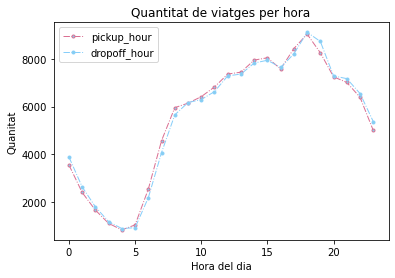

In [118]:
visualize_trips(['pickup_hour', 'dropoff_hour'], title = 'Quantitat de viatges per hora', xlabel = 'Hora del dia', ylabel = 'Quanitat')

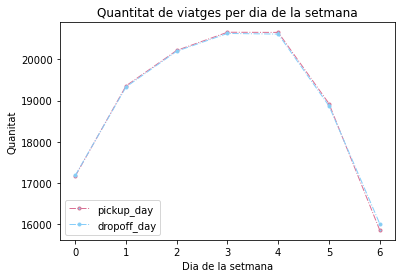

In [119]:
visualize_trips(['pickup_day', 'dropoff_day'], title = 'Quantitat de viatges per dia de la setmana', xlabel = 'Dia de la setmana', ylabel = 'Quanitat')

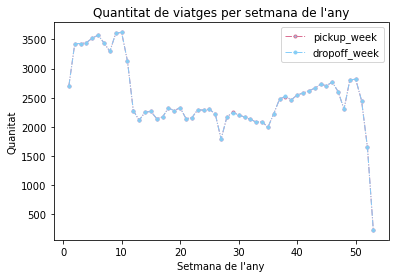

In [120]:
visualize_trips(['pickup_week', 'dropoff_week'], title = 'Quantitat de viatges per setmana de l\'any', xlabel = 'Setmana de l\'any', ylabel = 'Quanitat')

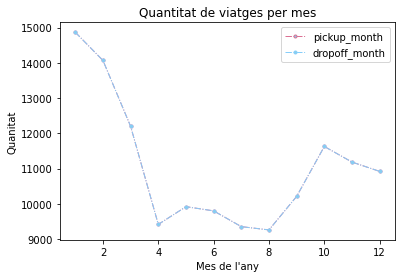

In [121]:
visualize_trips(['pickup_month', 'dropoff_month'], title = 'Quantitat de viatges per mes', xlabel = 'Mes de l\'any', ylabel = 'Quanitat')

**Pregunta: Quins comportaments veieu en cada cas? Quin creieu que és el motiu?**

> ANSWER: A partir de les gràfiques de línies organitzades segons la hora del dia, el dia de la setmana, setmana de l'any, i mes de l'any podem deduir que:
    
    1. Quantitat de viatges per hora: els rangs d'hores en les quals es realitzen més viatges són, d'entre 8:00-21:00, podrem observar que hi ha un gran canvi a partir de les 8.00, que és quan la gent va al treball, i a les 18:00, quu és quan la gent plega.
    2.De la quantitat de viatges que s'han realitzat en dies de la setmana podrem veure que aquest número va creixent a mesura que va avançant la setmana i el divendres arriba al punt més alt, mentre en els caps de setmana comença a reduir, de la gràfica podem deduir que aquests viatges es realitzen probablement per motius de treball, i la gent descansa al cap de setmana.
    3. De la quantitat de viatges que es realitzen per semanes de l'any, podem veure que les primeres setmanes de l'any són les setmanes que la gent més es desplaça, el motiu per la qual fa que la gent es desplaci pot ser que s'han acabat les vancances i per exemple, tornen al treball, o estudiants comencen les classes.
    4. I dels viatges que es realitzen per mes, vuerem que gener és el mes amb més viatges realitzades, perquè la gent comença a treballar.

## 04. Relació distancia - temps i velocitat

A les dades tenim la distància que ha recorregut el taxi en cada viatge i de la informació temporal podem extreure també la duració d'aquest.


Intentarem esbrinar com la covid va afectar les distàncies i les durades dels viatges juntament amb la velocitat dels taxis.

Creieu que la densitat de trànsit va variar?

### Histogrames

Per començar visualitza els **histogrames** de distància i durada per any.

Pots fer servir la funció *plt.hist()* o *plt.bar()*.

In [122]:
#afegim la columna que indica la durada del viatge
# cada element obtingut d'aquesta columna és un Timedelta, d'aquesta forma obtenim els valors en unitats de hores
df['trip_duration'] = (df['tpep_dropoff_datetime'] - df['tpep_pickup_datetime'])/pd.Timedelta(hours=1)
            
# agafem només les dades que tinguin una durada normal
viatges_no_llargs = df['trip_duration'] < 6
viatges_valids = df['trip_duration'] > 0
df = df[viatges_no_llargs & viatges_valids]

In [138]:
def histograms_plot(histograms, xlabel, ylabel, title, xlim):
    """
    Funció que crea histogrames a partir del dataframe i la columna que conté la informació
    """
    
    figure = plt.figure(figsize=(15,15))
    
    for index,year in enumerate(histograms):
        # mostrem el diagrama de barres
        figure.add_subplot(1,3,(index+1))
        plt.hist(year, bins = 80, edgecolor = 'none', color= COLORS[index], range = xlim)
        plt.xlabel(xlabel)
        plt.ylabel(ylabel)
        plt.title(title + ' ' + str(YEARS[index]))
        plt.xlim(xlim)
        
        if title == 'Distancia dels viatges per any':
            plt.ylim((0,35000))
        else:
            plt.ylim((0,80000))

In [139]:
def visualize_histograms(df, column, title, xlabel, ylabel, xlim):
    histograms = []
    for year in YEARS:
        condicio = df['year'] == year
        serie = df.loc[condicio, column]
        histograms.append(serie)
    histograms_plot(histograms,xlabel, ylabel, title, xlim)

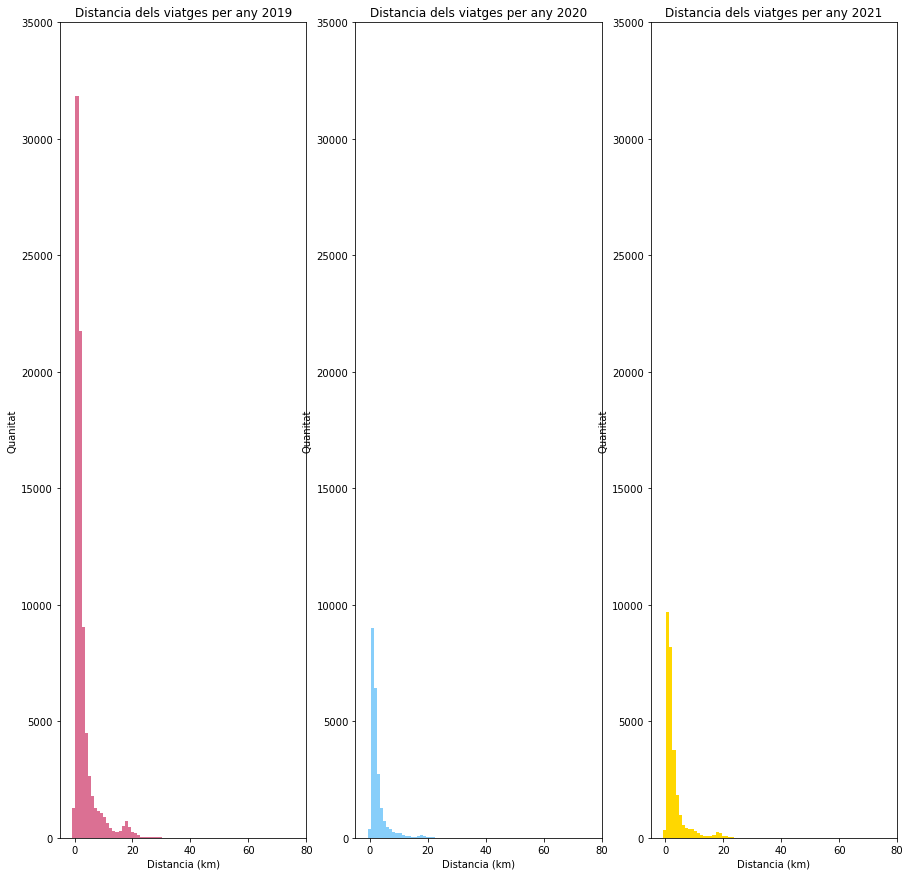

In [140]:
visualize_histograms(df, 'trip_distance', title = 'Distancia dels viatges per any',xlabel = 'Distancia (km)', ylabel = 'Quanitat', xlim = (-5, 80))

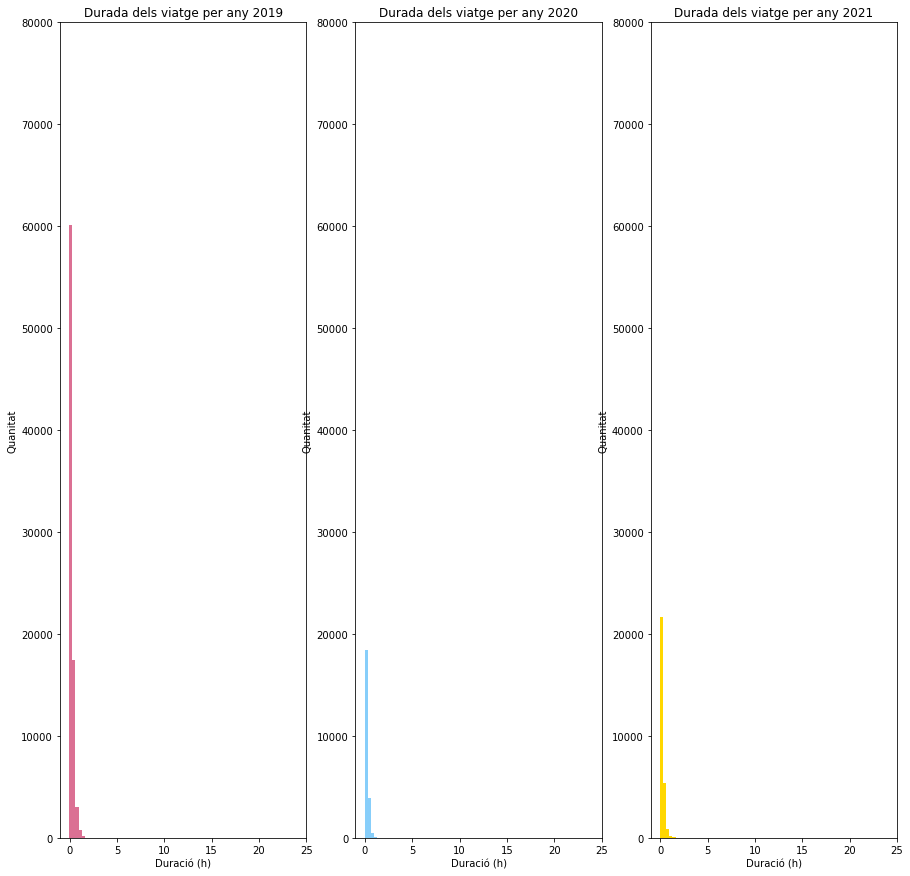

In [142]:
visualize_histograms(df, 'trip_duration', title = 'Durada dels viatge per any',xlabel = 'Duració (h)', ylabel = 'Quanitat', xlim = (-1, 25) )

**PREGUNTES:** 

* Com creieu que la covid va afectar les distàncies i durades dels viatges?

* I a la velocitat dels taxis?

> ANSWER

### Gràfic de dispersió i correlació

Crea gràfics de dispersió per il·lustrar la relació entre la durada i la distància dels viatges.

Es possible que les dades continguin mostres fora la distribució (outliers). En aquest cas, omet aquestes dades i torna a visualitzar el grafic.

Per veure si existeix alguna correlació, es interesant que utilitzeu la funció *sns.regplot()*.

In [231]:
def compute_outliers(data):
    """
    Funció que retorna una una serie de boolean amb tots els valors valids sent data un Series
    """
    threshold = 3
    mean = np.mean(data)
    std = np.std(data)
    
    condicio = np.abs((data - mean)/std) < threshold
    return condicio

In [232]:
def scatter_plot(df, x_value, y_value, xlabel, ylabel, remove_outliers = False):
    """
    Funció que mostra un scatter plot donades dues dades
    """
    taula = df
    taula['trip_duration'] = (df['tpep_dropoff_datetime'] - df['tpep_pickup_datetime'])/pd.Timedelta(hours=1)
    # agafem només les dades que tinguin una durada normal
    viatges_no_llargs = taula['trip_duration'] < 6
    taula = taula[viatges_no_llargs]

    if remove_outliers:
        # apliquem z_score per eliminar els valors invalids de la gràfica
        condicio1 = compute_outliers(taula[x_value])
        condicio2 = compute_outliers(taula[y_value])
        taula = taula.loc[condicio1 & condicio2]
    
    # mostrem el gràfic de dispersió
    #plt.plot(x_value, y_value, data=df, linestyle='none', marker='o',markersize=0.7)
    sns.regplot(x=taula[x_value], y=taula[y_value],scatter_kws={'s':1},color=COLORS[0])
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    # configurem els rangs dels eixos per poder veure la diferècnia
    plt.xlim((0,80))
    plt.ylim((0,5))
    plt.show()

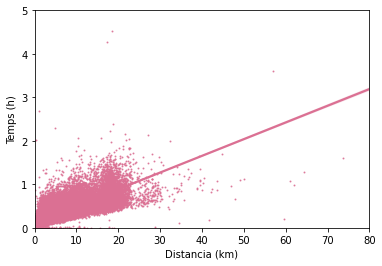

In [233]:
scatter_plot(df, 'trip_distance', 'trip_duration', 'Distancia (km)', 'Temps (h)')

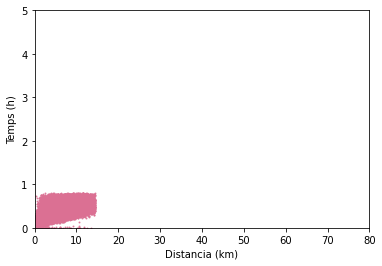

In [234]:
scatter_plot(df, 'trip_distance', 'trip_duration', 'Distancia (km)', 'Temps (h)', True)

**Pregunta: Pots veure alguna relació? Pots calcular la correlació entre les dades per treure més informació?**

> ANSWER: A partir del gràfic de disperció i correlació podem vuere que, a mesura que augmenta la distància, també augmenta el temps recorregut.

Tal com fèiem a l'apartat 3, visualitzeu les dades temporals i de distància a partir de les setmanes, i mesos de l'any.

In [245]:
df

,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,PULocationID,DOLocationID,payment_type,fare_amount,total_amount,year,trip_duration
0,2019-01-01 00:46:40,2019-01-01 00:53:20,1.0,1.50,151,239,1,7.0,9.95,2019,0.111111
1000,2019-01-01 00:53:09,2019-01-01 01:01:16,1.0,1.91,148,137,2,8.5,9.80,2019,0.135278
2000,2019-01-01 00:50:22,2019-01-01 01:19:44,2.0,7.70,264,264,1,26.0,31.30,2019,0.489444
3000,2019-01-01 00:54:46,2019-01-01 01:03:13,1.0,1.40,249,164,1,7.5,11.40,2019,0.140833
4000,2019-01-01 00:09:29,2019-01-01 00:12:29,2.0,0.67,162,137,2,4.0,5.30,2019,0.050000
...,...,...,...,...,...,...,...,...,...,...,...
3106000,2021-12-31 22:00:22,2021-12-31 22:04:55,2.0,1.00,107,170,1,5.5,11.15,2021,0.075833
3108000,2021-12-31 22:45:36,2021-12-31 22:55:16,1.0,1.64,211,158,2,9.0,12.80,2021,0.161111
3109000,2021-12-31 22:55:29,2021-12-31 23:05:10,1.0,1.49,79,164,2,8.0,11.80,2021,0.161389
3110000,2021-12-31 23:26:04,2021-12-31 23:29:32,5.0,0.90,263,236,1,5.0,11.00,2021,0.057778


<class 'pandas.core.indexes.numeric.Int64Index'>
week
1      8179.46
2      9111.67
3      9668.52
4      9353.08
5      9500.77
6      9954.40
7      9659.27
8      9558.04
9     10038.64
10    10644.02
11     8796.89
12     6627.41
13     6268.69
14     7035.62
15     6494.92
16     6205.38
17     6530.95
18     6834.24
19     6810.11
20     6579.60
21     6700.51
22     7055.24
23     6926.27
24     6905.15
25     7014.90
26     6992.61
27     5938.37
28     6810.49
29     7059.48
30     7000.77
31     6577.76
32     6714.87
33     6526.70
34     6831.88
35     6322.24
36     7135.87
37     7294.42
38     7333.71
39     7519.34
40     7476.35
41     7575.01
42     7918.09
43     7825.73
44     7904.97
45     8200.64
46     8188.10
47     7408.39
48     6964.21
49     8727.37
50     8778.31
51     7500.48
52     5216.72
53      753.11
Name: trip_distance, dtype: float64


<AxesSubplot:xlabel='week'>

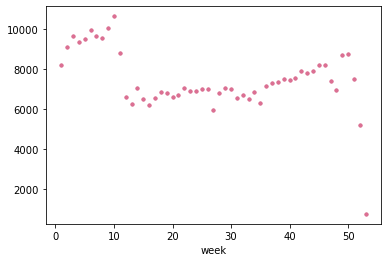

In [154]:
# obte la setmana de cada linia de la columna tpep_pickup_datetime
pick = pd.Int64Index(pd.DatetimeIndex(df['tpep_pickup_datetime']).isocalendar().week)
print(type(pick))
serie = df.groupby(pick)['trip_distance'].sum()
print(serie)
#serie['trip_distance'].size()
#print(type(serie))
len(serie)
serie.plot(style='.', color = COLORS[0])

In [193]:
def visualize_per_period(df, column_data, columns, xlabel, ylabel, title):
    """
    Funció que visualitza la distància / duració mitjanes dels trajectes en un temps a determinar
    """
    taula_any = df
    figure = plt.figure(figsize=(15,15))
    for index,year in enumerate(YEARS):
        # agafem només les dades 
        taula_any = df[df['year'] == year]
        if columns[0] == 'pickup_week':
            pick = pd.Int64Index(pd.DatetimeIndex(df['tpep_pickup_datetime']).isocalendar().week)
            drop = pd.Int64Index(pd.DatetimeIndex(df['tpep_dropoff_datetime']).isocalendar().week)

        elif columns[0] == 'pickup_month':
            pick = pd.DatetimeIndex(df['tpep_pickup_datetime']).month
            drop = pd.DatetimeIndex(df['tpep_dropoff_datetime']).month

        # obtenim la mitjana de kms/hores de cada temporada requerida
        serie_pick = df.groupby(pick)[column_data].mean()
        serie_drop = df.groupby(drop)[column_data].mean()
        
        figure.add_subplot(3,1,(index+1))
        serie_pick.plot(style='.', color = COLORS[0], label = 'pick up')
        serie_pick.plot(style='.', color = COLORS[1], label = 'drop off', alpha = 0.4)
        plt.xlabel(xlabel)
        plt.ylabel(ylabel)
        plt.ylim((0,4))
        plt.title(title + ' ' + str(year))
        plt.legend()

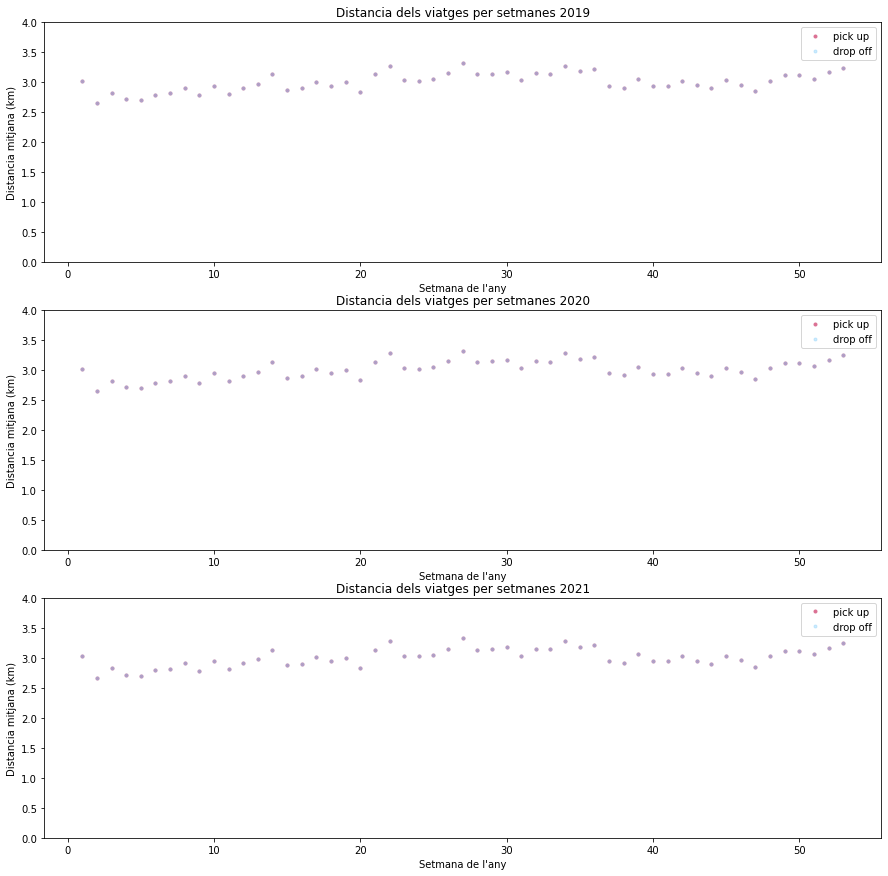

In [194]:
visualize_per_period(df, 'trip_distance', columns = ['pickup_week', 'dropoff_week'],
                    xlabel = 'Setmana de l\'any', ylabel = 'Distancia mitjana (km)', title = 'Distancia dels viatges per setmanes')

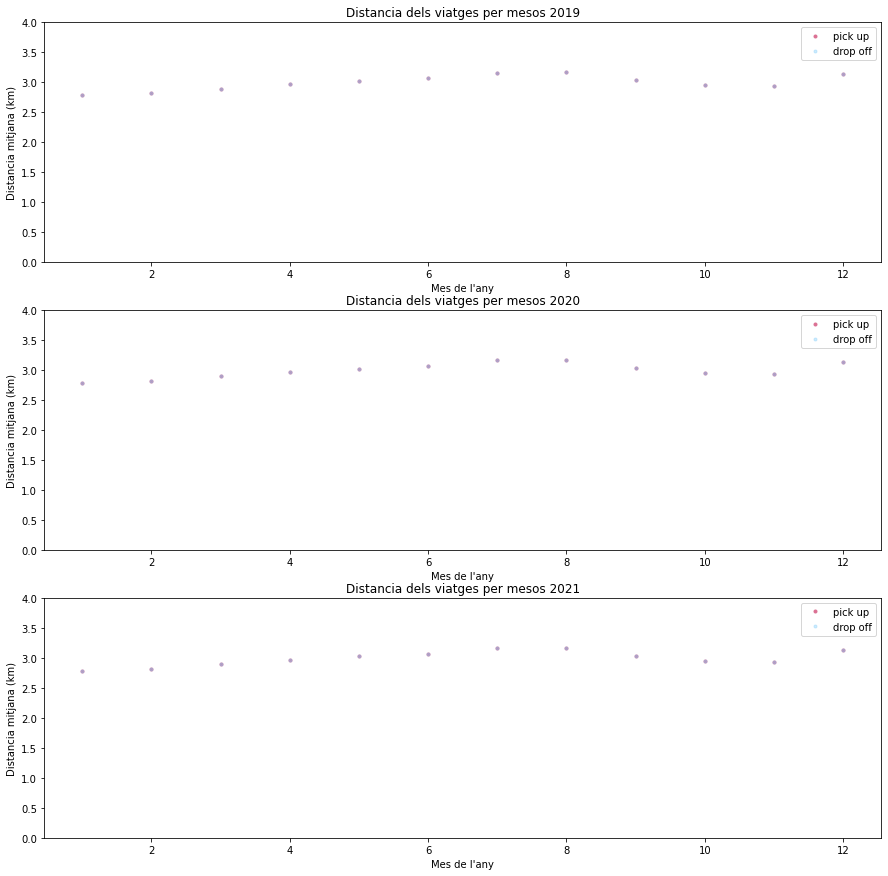

In [195]:
visualize_per_period(df, 'trip_distance', columns = ['pickup_month', 'dropoff_month'],
                     xlabel = 'Mes de l\'any', ylabel = 'Distancia mitjana (km)', title = 'Distancia dels viatges per mesos')

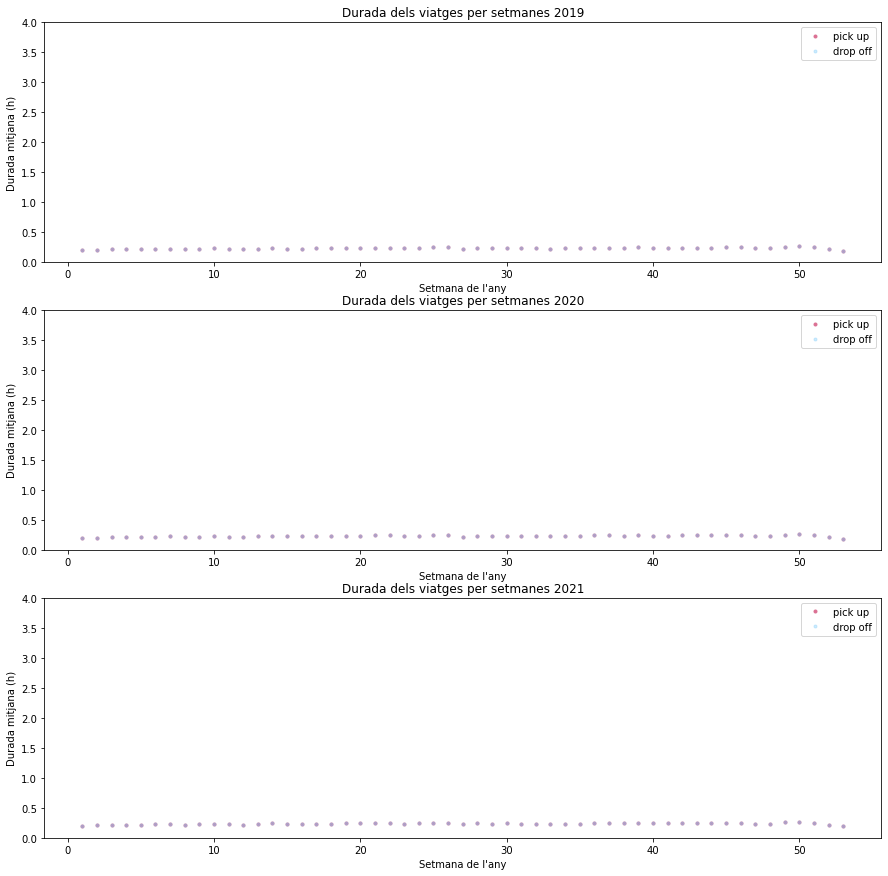

In [196]:
visualize_per_period(df, 'trip_duration', columns = ['pickup_week', 'dropoff_week'],
                     xlabel = 'Setmana de l\'any', ylabel = 'Durada mitjana (h)', title = 'Durada dels viatges per setmanes')

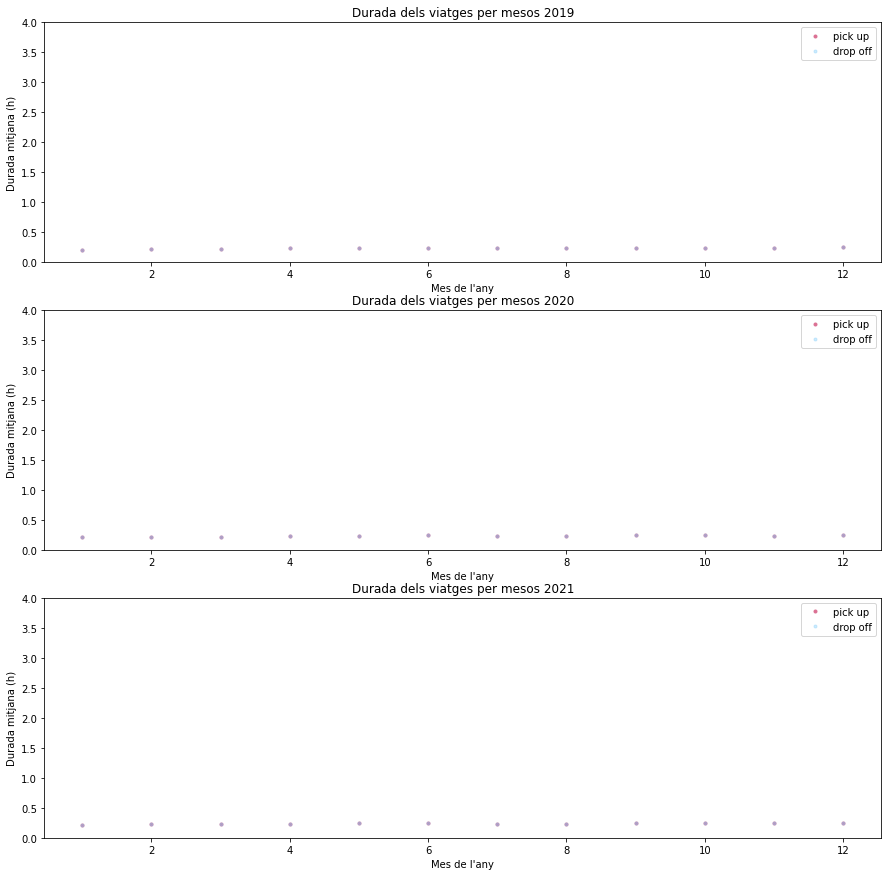

In [197]:
visualize_per_period(df, 'trip_duration', columns = ['pickup_month', 'dropoff_month'],
                     xlabel = 'Mes de l\'any', ylabel = 'Durada mitjana (h)', title = 'Durada dels viatges per mesos')

**Pregunta: Hi ha algun comportament estrany a part de la covid? Per què pot ser causat?**
    
> ANSWER

Fins ara hem mostrat les dades de manera agregada.

Per tal de visualitzar-ho de manera global, utilitzarem la funció *plt.imshow()* que visualitza imatges i, per tant, matrius.

Implementa una funció que visualitzi per any:

- un mapa de calor que indiqui a quina hora del dia hi ha viatges més llargs durant l'any.
- un mapa de calor que indiqui a quina hora del dia hi ha viatges més llargs durant la setmana.

In [64]:
df

,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,PULocationID,DOLocationID,payment_type,fare_amount,total_amount,year,pickup_hour,pickup_day,pickup_week,pickup_month,dropoff_hour,dropoff_day,dropoff_week,dropoff_month,trip_duration
0,2019-01-01 00:46:40,2019-01-01 00:53:20,1.0,1.50,151,239,1,7.0,9.95,2019,0,1,1,1,0,1,1,1,0 days 00:06:40
1,2019-01-01 00:59:47,2019-01-01 01:18:59,1.0,2.60,239,246,1,14.0,16.30,2019,0,1,1,1,1,1,1,1,0 days 00:19:12
7,2019-01-01 00:21:28,2019-01-01 00:28:37,1.0,1.30,163,229,1,6.5,9.05,2019,0,1,1,1,0,1,1,1,0 days 00:07:09
8,2019-01-01 00:32:01,2019-01-01 00:45:39,1.0,3.70,229,7,1,13.5,18.50,2019,0,1,1,1,0,1,1,1,0 days 00:13:38
9,2019-01-01 00:57:32,2019-01-01 01:09:32,2.0,2.10,141,234,1,10.0,13.00,2019,0,1,1,1,1,1,1,1,0 days 00:12:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10690,2021-12-01 07:45:25,2021-12-01 08:19:17,2.0,9.38,138,163,1,31.0,38.55,2021,7,2,48,12,8,2,48,12,0 days 00:33:52
10691,2021-12-01 07:37:21,2021-12-01 07:53:50,3.0,3.30,231,230,1,13.5,18.80,2021,7,2,48,12,7,2,48,12,0 days 00:16:29
10692,2021-12-01 07:35:05,2021-12-01 08:01:14,1.0,3.79,238,140,1,18.5,23.98,2021,7,2,48,12,8,2,48,12,0 days 00:26:09
10693,2021-12-01 07:51:59,2021-12-01 08:46:01,1.0,12.15,138,231,1,41.5,65.44,2021,7,2,48,12,8,2,48,12,0 days 00:54:02


In [ ]:
def heatmap(df, group, column_data, xlabel, ylabel, columns = None):
    """
    Funció que agrega les dades de manera adient per visualitzar un mapa de calor
    """
    
    # AQUÍ EL TEU CODI
    raise NotImplementedError

In [ ]:
heatmap(df, ['pickup_hour', 'pickup_dayofyear'], 'trip_duration', 'Dies de l\'any', 'Hores del dia')

In [ ]:
heatmap(df, ['pickup_hour', 'pickup_day'], 'trip_duration', 'Hores del dia', 'Dies de la setmana', ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])

Repeteix els gràfics anteriors visualitzant la distancia.

In [ ]:
heatmap(df, ['pickup_hour', 'pickup_dayofyear'], 'trip_distance', 'Dies de l\'any', 'Hores del dia')

In [ ]:
heatmap(df, ['pickup_hour', 'pickup_day'], 'trip_distance', 'Hores del dia', 'Dies de la setmana', ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])

Per últim, visualitza la velocitat mitjana a les diferents hores del dia durant la setmana.

In [ ]:
def speed_heatmap(df, group, xlabel, ylabel, columns = None):
    """
    Funció que agrega les dades de manera adient per visualitzar la velocitat un mapa de calor
    """
    # AQUÍ EL TEU CODI
    raise NotImplementedError

In [ ]:
speed_heatmap(df, ['pickup_hour', 'pickup_day'], 'Hores del dia', 'Dies de la setmana', ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])

**Pregunta: Quines conclusions treieu dels mapes de calor?**
    
> ANSWER

## 05. Visualitzem les localitzacions dels viatges

In [163]:
df.head()

,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,PULocationID,DOLocationID,payment_type,fare_amount,total_amount,year,trip_duration
0,2019-01-01 00:46:40,2019-01-01 00:53:20,1.0,1.50,151,239,1,7.0,9.95,2019,0.111111
1000,2019-01-01 00:53:09,2019-01-01 01:01:16,1.0,1.91,148,137,2,8.5,9.80,2019,0.135278
2000,2019-01-01 00:50:22,2019-01-01 01:19:44,2.0,7.70,264,264,1,26.0,31.30,2019,0.489444
3000,2019-01-01 00:54:46,2019-01-01 01:03:13,1.0,1.40,249,164,1,7.5,11.40,2019,0.140833
4000,2019-01-01 00:09:29,2019-01-01 00:12:29,2.0,0.67,162,137,2,4.0,5.30,2019,0.050000


Només tenim la ID d'una localització, per tant, necessitem aconseguir la latitud i la longitud.

La mateixa pàgina dels taxis ens dóna el fitxer *taxi_zones.zip*, però primer cal que convertim les dades de coordenades amb format WGS84.

Podem utilitzar aquesta web: https://mygeodata.cloud/

In [68]:
from utils import get_lat_lon, draw_region_map, draw_zone_map

In [77]:
sf = shapefile.Reader('data/geodata/taxi_zones.shp')

fields_name = [field[0] for field in sf.fields[1:]]
shp_dic = dict(zip(fields_name, list(range(len(fields_name)))))
attributes = sf.records()
shp_attr = [dict(zip(fields_name, attr)) for attr in attributes]

{'OBJECTID': 0, 'Shape_Leng': 1, 'Shape_Area': 2, 'zone': 3, 'LocationID': 4, 'borough': 5}


In [79]:
df_loc = pd.DataFrame(shp_attr).join(get_lat_lon(sf, shp_dic).set_index("LocationID"), on="LocationID")
df_loc.head()

,OBJECTID,Shape_Leng,Shape_Area,zone,LocationID,borough,longitude,latitude
0,1,0.116357,0.000782,Newark Airport,1,EWR,-74.171533,40.689483
1,2,0.433470,0.004866,Jamaica Bay,2,Queens,-73.822478,40.610824
2,3,0.084341,0.000314,Allerton/Pelham Gardens,3,Bronx,-73.844953,40.865747
3,4,0.043567,0.000112,Alphabet City,4,Manhattan,-73.977725,40.724137
4,5,0.092146,0.000498,Arden Heights,5,Staten Island,-74.187558,40.550664


NameError: name 'draw_region_map' is not defined

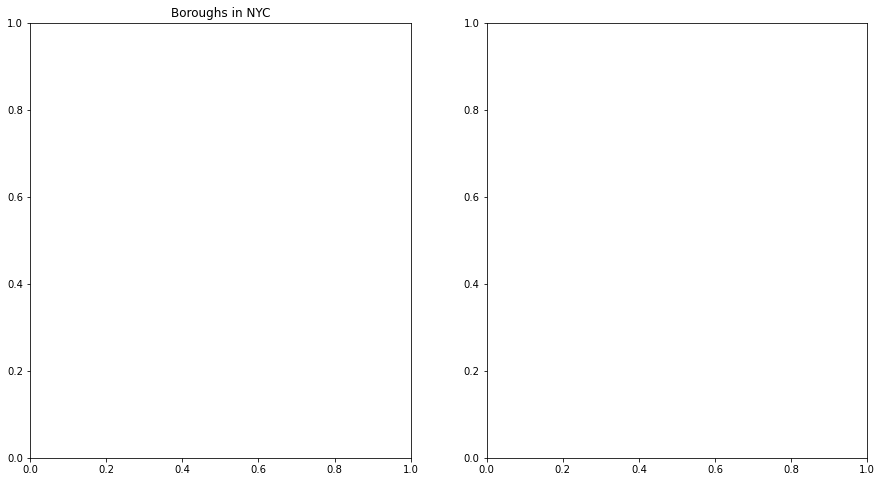

In [164]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15,8))
ax = plt.subplot(1, 2, 1)
ax.set_title("Boroughs in NYC")
draw_region_map(ax, sf, shp_dic)
ax = plt.subplot(1, 2, 2)
ax.set_title("Zones in NYC")
draw_zone_map(ax, sf, shp_dic)

Ara teniu dos dataframe que necessitem unir. Utilitza la funció *merge* per afegir la longitud i latitud al dataframe *df*:

In [83]:
# AQUÍ EL TEU CODI

merge = pd.merge(df,df_loc, left_on='PULocationID', right_on='LocationID')

In [84]:
merge.shape

(357299, 27)

## 06. ¿Quines zones tenen més recollides i quines zones tenen més entregues?

En aquest apartat volem conèixer i visualitzar les zones on els taxis són més utilitzats.

El primer pas és ordenar i guardar en una variable els llocs més comuns en la recollida i el destí.

Printa els 5 llocs més freqüents per any en cada cas.

In [160]:
# Recollida
# AQUÍ EL TEU CODI
top_pu = ...

# Destí
# AQUÍ EL TEU CODI
top_do = ...

In [161]:
n_top = 5
def show_top_n(df, column, df_loc, n_top = n_top):
    """
    Funció que mostra els llocs més usuals per any
    """
    # AQUÍ EL TEU CODI
    raise NotImplementedError

In [162]:
show_top_n(top_pu, 'PULocationID', df_loc)

NameError: name 'df_loc' is not defined

In [ ]:
show_top_n(top_do, 'DOLocationID', df_loc)

**Visualitzem amb un mapa de calor quines són les zones més recurrents**

In [145]:
for year in YEARS:
    PUcount = {k:v for k, v in top_do[top_do.year == year][['DOLocationID', 'trip_distance']].values}

    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12,5))
    ax = plt.subplot(1, 2, 1)
    ax.set_title(f"Zones with most pickups - {year}")
    draw_zone_map(ax, sf, shp_dic, heat=PUcount, text=list(PUcount.keys())[:3])
    ax = plt.subplot(1, 2, 2)
    ax.set_title(f"Zones with most drop-offs - {year}")
    draw_zone_map(ax, sf, shp_dic, heat=PUcount, text=list(PUcount.keys())[:3])

AttributeError: 'ellipsis' object has no attribute 'year'

**Pregunta: Per què creieu que la zona de Manhattan té més quantitat de viatges?**
> ANSWER

## 07. Hospitals

Com ha canviat la destinació dels viatges? Hi ha més gent que va als hospitals?

A la següent cel·la us donem la creació manual d'un DataFrame amb la localització més important dels hospitals de Nova York.

In [65]:
hospitals = [('New York’s Presbyterian Lower Manhattan Hospital, NYC, NY, USA', '40.710255', '-74.005058'),
('Manhattan Gastroenterology, NYC, NY, USA', '40.778259', '-73.958092'),
('Stem Cell Therapy Hospital, NYC, NY, USA', '40.601517', '-73.961067'),
('Park Avenue Smiles, Yonkers, NYC, NY, USA', '40.945873', '-73.890671'),
('Cosmetic Dentistry Center, NYC, NY, USA', '40.629234', '-74.026077'),
('Envy Smile Dental Spa, Brooklyn, NYC, NY, USA', '40.607059', '-73.960144'),
('VIVA EVE, Forest Hills, NYC, NY, USA', '40.734291', '-73.849434'),
('Forest Hills Medical Services, Queens, NYC, NY, USA', '40.734310', '-73.849510'),
('Professional Gynecological Services, Brooklyn, NY, NY, USA', '40.689747', '-73.982346'),
('Manhattan Womens Health & Wellness, New York, NY, USA', '40.741997', '-73.986107'),
('Brooklyn Abortion Clinic, Brooklyn, NY, New York, USA', '40.689743', '-73.982368'),
('Brooklyn GYN Place, Brooklyn, NY, USA', '40.692696', '-73.993584'),
('Americas Holistic Doctor, NYC, NY, USA', '40.742531', '-73.985489'),
('NJS Physical Medicine & Rehabilitation, Brooklyn, NY, USA', '40.641621', '-73.956734'),
('DHD Medical, Brooklyn New York, USA', '40.625568', '-73.918320'),
('Workers Compensation Doctor, New York, NY, USA', '40.652225', '-74.006104'),]

hospitals = pd.DataFrame(hospitals, columns = ['Place Name', 'Latitude', 'Longitude'])
hospitals['Latitude'] = hospitals['Latitude'].astype(float)
hospitals['Longitude'] = hospitals['Longitude'].astype(float)
hospitals.head()

,Place Name,Latitude,Longitude
0,New York’s Presbyterian Lower Manhattan Hospit...,40.710255,-74.005058
1,"Manhattan Gastroenterology, NYC, NY, USA",40.778259,-73.958092
2,"Stem Cell Therapy Hospital, NYC, NY, USA",40.601517,-73.961067
3,"Park Avenue Smiles, Yonkers, NYC, NY, USA",40.945873,-73.890671
4,"Cosmetic Dentistry Center, NYC, NY, USA",40.629234,-74.026077


Utilitza la latitud i longitud de cada hospital i la de les zones del dataframe *merge* per veure la distribució dels hospitals.

Per fer-ho utilitza els gràfics de dispersió. Recorda que s'entendrà millor si els punts són transparents (paràmetre *alpha*).

Després repeteix el mateix gràfic però separat per any. 

In [66]:
def scatter_locations(merge, hospitals):
    """Funció que mostra la distribució dels hospitals i les destinacions dels taxis"""
    # AQUÍ EL TEU CODI
    raise NotImplementedError

In [67]:
scatter_locations(merge, hospitals)

NameError: name 'merge' is not defined

In [ ]:
def scatter_locations_per_year(merge, hospitals):
    """Funció que mostra la distribució dels hospitals i les destinacions dels taxis"""
    # AQUÍ EL TEU CODI
    raise NotImplementedError

In [ ]:
scatter_locations_per_year(merge, hospitals)

**Pregunta: Veus algun comportament?**
>ANSWER

Per poder conèixer com ha variat els trajectes als hospitals, primer cal detectar a quina localització del mapa pertany cada hospital.

Per fer això cal calcular les distàncies. No calculeu la distància punt a punt, sinó matricialment.

In [ ]:
from scipy.spatial import distance_matrix

In [ ]:
hospitals_loc = hospitals[['Longitude', 'Latitude']].values
loc = df_loc[['longitude', 'latitude']].values


# AQUÍ EL TEU CODI    
dist = ...

In [ ]:
plt.figure(figsize=(20, 5))
plt.imshow(dist)

Trobeu la manera de localitzar el sector més proper a partir de les distàncies.

In [ ]:
# AQUÍ EL TEU CODI
hospitals_locations = ...
hospitals['LocationID'] = hospitals_locations

In [ ]:
hospitals.head()

Ara que ja tenim en quin sector es troben els hospitals, visualitzeu quants trajectes hi ha relacionats amb ells.

Suposarem que tots els trajectes al sector van a l'hospital.

Feu una única figura amb dos gràfics de barres on es mostrin la quantitat de viatges per cada any i el % del total dels viatges.

In [ ]:
def trips_hospitals(df, hospitals_locations):
    """
    Funció que mostra una única figura amb dos gràfics de barres on es mostrin la quantitat de viatges per cada any i el % del total dels viatges.
    """
    # AQUÍ EL TEU CODI
    raise NotImplementedError

In [ ]:
trips_hospitals(df, hospitals_locations)

## 08. Qui escolta pels forats, sent els seus pecats

A la **primera part** heu de visualitzar i comentar els exemples que hem eliminat, com distancies molt llargues, molt curtes...

A la **segona part** teniu llibertat per escollir i fer visualitzacions que us aportin informació extra que no s'hagi vist anteriorment.

# 1

In [311]:
def get_invalid(data, year, month,sampling = 1000):
    """
    Funció que visualitza totes les dades que hem volgut eliminar
    """
    invalides = data[required_data]
    if sampling != 0:
        invalides = invalides[::sampling]

    # La recollida és després que la finalització del trajecte.
    df1 = invalides[invalides['tpep_dropoff_datetime'] <= invalides['tpep_pickup_datetime']]
    
    # Les dades s'importen per mes i any. Les dates són correctes?
    # extreurem el mes i l'any amb la comanda -> pd.DatetimeIndex(df['birth_date']).year /  pd.DatetimeIndex(df['birth_date']).month
    any_pick = pd.DatetimeIndex(invalides['tpep_pickup_datetime']).year != year
    any_pick_igual = pd.DatetimeIndex(invalides['tpep_pickup_datetime']).year == year
    mes_pick = pd.DatetimeIndex(invalides['tpep_pickup_datetime']).month != month
    mes_pick_igual = pd.DatetimeIndex(invalides['tpep_pickup_datetime']).month == month
    any_drop = pd.DatetimeIndex(invalides['tpep_dropoff_datetime']).year == year
    any_drop_igual = pd.DatetimeIndex(invalides['tpep_dropoff_datetime']).year != year
    mes_drop = pd.DatetimeIndex(invalides['tpep_dropoff_datetime']).month == month
    mes_drop_igual = pd.DatetimeIndex(invalides['tpep_dropoff_datetime']).month != month
    # mentre quaslevol d'aquests quatre no coincideixi:
    df2 = invalides[(any_pick & any_drop) | (mes_pick & mes_drop) | (any_pick_igual & any_drop_igual) | (mes_pick_igual & mes_drop_igual)]

    # dades amb menys d'un passatger o més de 9 passatgers
    condicio = invalides['passenger_count'] <= 0
    condicio2 = invalides['passenger_count'] > 9
    df3 = invalides[condicio | condicio2]

    # Viatges molts llargs o molt curts
    viatges_invalids = invalides['trip_distance'] <= 0
    viatges_llargs = invalides['trip_distance'] > 100
    df4 = invalides[viatges_invalids | viatges_llargs]

    # pagaments negatius
    no_pagats = invalides['total_amount'] <= 0
    df5 = invalides[no_pagats]
    
    frames = [df1,df2,df3,df4,df5]
    invalides = pd.concat(frames)
    return invalides

In [312]:
invalides = pd.concat([get_invalid(load_table(year, month), year, month,0) for year in tqdm(YEARS) for month in tqdm(range(1, 13), leave = False)])

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

In [313]:
# aquí veurem alguns exemples de les dades que hem eliminat:
invalides

,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,PULocationID,DOLocationID,payment_type,fare_amount,total_amount
28,2019-01-01 00:32:59,2019-01-01 00:32:59,3.0,0.00,237,264,2,6.50,7.80
681,2019-01-01 00:39:07,2019-01-01 00:39:07,1.0,0.00,142,264,2,2.50,3.80
3552,2019-01-01 00:18:46,2019-01-01 00:18:46,1.0,0.00,186,264,2,0.00,0.00
3661,2019-01-01 00:54:29,2019-01-01 00:54:29,1.0,0.00,249,264,2,2.50,3.80
4573,2019-01-01 00:58:14,2019-01-01 00:58:14,1.0,0.00,158,264,2,33.50,34.80
...,...,...,...,...,...,...,...,...,...
3203328,2021-12-24 19:24:00,2021-12-24 19:25:00,NaN,0.07,163,163,0,-26.80,-20.00
3203837,2021-12-25 06:21:00,2021-12-25 06:34:00,NaN,6.43,74,113,0,-40.52,-31.57
3204366,2021-12-25 14:56:00,2021-12-25 14:58:00,NaN,0.04,87,87,0,-28.81,-21.70
3211118,2021-12-30 01:13:46,2021-12-30 01:14:47,NaN,0.03,230,230,0,-28.93,-21.80


-De les primeres línies, podem vuere que són invàlides perquè la distància recorreguda és 0 i a més perquè el temps de dropoff coincideix amb el temps de pickup, a part podem vuere que el valor del total_amount és 0.

-Les últimes línies que ens mostra no s'ha grabat correctament el nombre de passatgers en el taxi, llavors també les considerem invàlides, a part d'això, també podem observar que als total_amount són números negatius, la qual també ens indica que es tracta de dades invalides.


In [314]:
any_pick = pd.DatetimeIndex(invalides['tpep_pickup_datetime']).year != 2020
any_drop = pd.DatetimeIndex(invalides['tpep_dropoff_datetime']).year == 2020
# mentre quaslevol d'aquests quatre no coincideixi:
df1 = invalides[any_pick & any_drop]
df1

,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,PULocationID,DOLocationID,payment_type,fare_amount,total_amount
4449188,2019-12-31 16:56:40,2020-01-01 00:04:10,1.0,0.98,100,234,2,6.0,10.30
6677776,2019-12-31 00:30:29,2020-01-01 00:20:14,1.0,2.23,43,163,2,8.5,12.30
6678255,2019-12-31 00:53:06,2020-01-01 00:35:45,5.0,4.20,43,7,1,14.5,21.96
6678398,2019-12-31 00:57:14,2020-01-01 00:30:22,1.0,1.10,48,50,1,5.5,10.70
6679487,2019-12-31 00:16:28,2020-01-01 00:03:29,2.0,1.05,186,230,1,6.0,11.76
...,...,...,...,...,...,...,...,...,...
58319,2019-12-31 16:14:49,2020-01-01 15:24:15,1.0,1.57,261,144,1,8.5,13.30
65522,2019-12-31 15:59:29,2020-01-01 15:31:22,1.0,16.17,164,132,1,45.5,50.80
65523,2019-12-31 16:11:56,2020-01-01 15:21:19,1.0,1.99,68,107,1,9.0,14.51
556110,2021-01-15 07:27:40,2020-10-13 12:03:02,1.0,1.60,161,234,1,9.0,13.30


Tampoc hem considerat aquests casos en les quals el temps de pickup i dropoff no pertany al mateix any o mes.

In [316]:
# dades amb menys d'un passatger o més de 9 passatgers
condicio2 = invalides['passenger_count'] > 9
df2 = invalides[condicio2]
df2

,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,PULocationID,DOLocationID,payment_type,fare_amount,total_amount
57956,2021-08-01 19:47:43,2021-08-01 19:57:54,112.0,1.80,79,234,1,9.0,14.76
171072,2021-08-03 11:51:58,2021-08-03 12:09:29,96.0,1.56,100,137,1,11.5,17.02


Tampoc hem considerat els viatges que tenen un nombre de passatgers exagerat

In [319]:
viatges_invalids = invalides['trip_distance'] < 0
df3 = invalides[viatges_invalids]
df3

,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,PULocationID,DOLocationID,payment_type,fare_amount,total_amount
6878088,2019-11-30 23:49:00,2019-12-01 00:12:00,NaN,-5.02,50,232,0,14.81,21.11
6878101,2019-11-30 23:15:00,2019-12-01 00:00:00,NaN,-10.50,50,102,0,45.65,49.20
4641728,2019-11-20 16:51:31,2019-11-20 17:51:56,1.0,-11.45,45,74,2,39.59,39.59
4650415,2019-11-20 16:13:00,2019-11-20 16:38:15,1.0,-4.69,155,35,2,47.80,48.60
4663082,2019-11-20 17:06:09,2019-11-20 18:37:19,1.0,-14.42,79,215,1,50.16,50.16
...,...,...,...,...,...,...,...,...,...
6378673,2020-01-15 22:34:00,2020-01-15 23:00:00,NaN,-6.55,232,72,0,35.95,39.50
6378683,2020-01-15 22:10:00,2020-01-15 23:01:00,NaN,-23.03,48,55,0,46.51,56.18
6358072,2020-01-08 15:08:10,2020-01-08 15:10:00,NaN,-0.01,75,75,0,-36.04,-35.24
6358074,2020-01-08 15:08:10,2020-01-08 15:10:00,NaN,-0.01,75,75,0,-36.04,-35.24


Les línies amb una distància negativa o igual a 0 seran eliminades

In [321]:
viatges_llargs = invalides['trip_distance'] > 1000
df4 = invalides[viatges_llargs]
df4

,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,PULocationID,DOLocationID,payment_type,fare_amount,total_amount
3133914,2019-06-14 10:53:40,2019-06-14 10:54:57,1.0,45977.22,193,193,2,0.00,0.00
3133914,2019-06-14 10:53:40,2019-06-14 10:54:57,1.0,45977.22,193,193,2,0.00,0.00
704581,2019-12-04 10:20:13,2019-12-04 10:24:43,1.0,19130.18,224,224,2,11.00,11.00
6397623,2020-01-28 07:37:00,2020-01-28 08:42:00,NaN,210240.07,76,231,0,37.77,41.32
6254657,2020-02-04 06:56:00,2020-02-04 07:56:00,NaN,50769.78,29,87,0,35.46,45.13
...,...,...,...,...,...,...,...,...,...
3207316,2021-12-27 13:27:00,2021-12-27 13:38:00,NaN,59694.97,66,13,0,13.20,20.05
3211141,2021-12-30 03:52:00,2021-12-30 04:05:00,NaN,118228.10,151,161,0,17.41,25.20
3211348,2021-12-30 08:11:00,2021-12-30 08:58:00,NaN,100281.62,165,86,0,51.30,57.30
3213507,2021-12-31 15:45:00,2021-12-31 16:06:00,NaN,65380.00,211,265,0,30.25,49.10


També hi han viatges amb una distància massa llarga, aquests no estarn inclosos.

# 2

In [324]:
df

,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,PULocationID,DOLocationID,payment_type,fare_amount,total_amount
0,2019-01-01 00:46:40,2019-01-01 00:53:20,1.0,1.50,151,239,1,7.0,9.95
1000,2019-01-01 00:53:09,2019-01-01 01:01:16,1.0,1.91,148,137,2,8.5,9.80
2000,2019-01-01 00:50:22,2019-01-01 01:19:44,2.0,7.70,264,264,1,26.0,31.30
3000,2019-01-01 00:54:46,2019-01-01 01:03:13,1.0,1.40,249,164,1,7.5,11.40
4000,2019-01-01 00:09:29,2019-01-01 00:12:29,2.0,0.67,162,137,2,4.0,5.30
...,...,...,...,...,...,...,...,...,...
3106000,2021-12-31 22:00:22,2021-12-31 22:04:55,2.0,1.00,107,170,1,5.5,11.15
3108000,2021-12-31 22:45:36,2021-12-31 22:55:16,1.0,1.64,211,158,2,9.0,12.80
3109000,2021-12-31 22:55:29,2021-12-31 23:05:10,1.0,1.49,79,164,2,8.0,11.80
3110000,2021-12-31 23:26:04,2021-12-31 23:29:32,5.0,0.90,263,236,1,5.0,11.00


## 09. Informe

A partir de l'exploració de les dades que heu fet al llarg d'aquest notebook, feu un petit informe resumint i justificant tots els canvis que han sorgit a causa de la covid.

In [ ]:
def tests(df):
    '''
    condicio = df['year'] == 2020
    taula2020 = df.loc[condicio]
    taula2020.head(10)

    taula2020['passenger_count'].count()
    # recompte amb size()
    taula = taula2020.groupby('passenger_count').size()
    taula
    #print(type(taula))

    #fig, axs = plt.subplots(1, 3, figsize = (10, 10)) # (rows, columns, panel number)
    #axs[0].plot(taula)
    #axs[1] = taula.plot.bar('Nombre de passatgers', 'Recompte de passatgers', ylim = (0,6000))
    #axs[2] = taula.plot.bar('Nombre de passatgers', 'Recompte de passatgers', ylim = (0,7000))
    
    condicio = df['year'] == 2020
    taula_any = df.loc[condicio]
    print(type(taula_any))
    figure = plt.figure(figsize=(15,10))

    serie = taula_any.groupby('passenger_count').size()
    serie
    print(type(serie))
    figure.add_subplot(2, 2, 1)
    serie.plot(kind = 'bar',color = 'pink')
    plt.xlabel('Nombre de passatgers')
    plt.title(" 2020")
    plt.ylabel('ylabel')
    plt.ylim((0,6000))

    data2020 =  taula_any["passenger_count"].groupby(taula_any["passenger_count"]).count()
    data2020
    print(type(data2020))
    figure.add_subplot(2, 2, 2)
    data2020.plot(kind='bar', color="b")
    plt.xlabel('Nombre de passatgers')
    plt.title(" 2020")
    plt.ylabel('ylabel')
    plt.ylim((0,6000))
    '''
    '''
    condicio = df['year'] == 2020
    taula_any = df.loc[condicio]
    taula_any.head(10)
    #serie = taula_any.groupby('passenger_count').size()
    
    '''
    
    '''
    condicio = df['year'] == 2020
    taula_any = df.loc[condicio]
    taula_any.head(10)
    mitja = taula_any['passenger_count'].sum()
    taula_any.head(10)
    recompte = taula_any.groupby('passenger_count').size()
    recompte
    print(type(recompte))
    recompte = recompte/mitja
    recompte
    '''

In [138]:
def test2():
    '''
    condicio = df['year'] == 2020
    taula_any = df.loc[condicio]
    serie = taula_any.groupby('passenger_count').size()
    print(type(serie))
    condicio2 = df['year'] == 2021
    taula_any2 = df.loc[condicio2]
    serie2 = taula_any2.groupby('passenger_count').size()
    print(type(serie2))

    # grouped barplot
    barWidth = 0.25

    # Set position of bar on X axis
    r1 = np.arange(len(serie))
    r2 = [x + barWidth for x in r1]

    # Make the plot
    plt.bar(r1, serie, color='#7f6d5f', width=barWidth, edgecolor='white', label='var1')
    plt.bar(r2, serie2, color='#557f2d', width=barWidth, edgecolor='white', label='var2')

    # Add xticks on the middle of the group bars
    plt.xlabel('group', fontweight='bold')
    plt.xticks([r + barWidth for r in range(len(serie))], ['1', '2', '3', '4', '5','6'])

    #r3 = [x + barWidth for x in r2]
    
    r1 = np.arange(len(serie))
    r1
    
    
    
    '''
    '''
    condicio = df['year'] == 2020
    taula_any = df.loc[condicio]
    '''
    '''
    hora = pd.DatetimeIndex(df['tpep_pickup_datetime']).hour
    dades = df.groupby(hora).size()
    dades
    '''
    '''
    hora = pd.Int64Index(pd.DatetimeIndex(df['tpep_pickup_datetime']).isocalendar().week)
    print(type(hora))

    dades = df.groupby(hora).size()
    print(type(dades))
    dades = dades.to_frame()
    print(type(dades))

    plt.plot(dades, marker='o', markerfacecolor='olive', markersize=5, color='olive', linewidth=2, linestyle='dashed', label="toto")
    # show legend
    plt.legend()

    # show graph
    plt.show()
    '''

In [199]:
"""
figure = plt.figure(figsize=(20,20))

condicio = df['year'] == 2019
taula_any = df.loc[condicio]
serie = taula_any.groupby('trip_distance').size()
serie
pos = np.arange(80)
print(pos)

df2019 = df.loc[((pd.DatetimeIndex(df["tpep_dropoff_datetime"]).year) == 2019)]
data2019 = (df2019["tpep_dropoff_datetime"].dt.hour - df2019["tpep_pickup_datetime"].dt.hour) + (df2019["tpep_dropoff_datetime"].dt.minute - df2019["tpep_pickup_datetime"].dt.minute)/60 + (df2019["tpep_dropoff_datetime"].dt.second - df2019["tpep_pickup_datetime"].dt.second)/120 
data2019
figure = plt.figure(figsize=(15,10))
    
# Fem el plot amb els 3 histogrames
figure.add_subplot(2,3,1)
#plt.hist(data2019, bins=30, alpha=0.8, range = (0,80), histtype='stepfilled', color='darkorchid',edgecolor='none')
#xstick = np.arange(80)
#figure.add_subplot(2,3,1)
plt.hist(serie)
#condi = df2019['trip_distance'] >= 50
#condi
#taula = df2019.loc[condi]
#taula
#plt.xticks([r + 0.25 for r in range(len(serie))], xstick)
#plt.bar(pos2,serie,color = COLORS[0],width=0.25, edgecolor='None')
#plt.bar(pos, serie, color = COLORS[0], width=0.25, edgecolor='white', label=str(YEARS[0]))
#plt.show()

# plt.hist(serie,bins = 80, edgecolor = 'white', color='steelblue', range = (-5, 80))
"""

'\nfigure = plt.figure(figsize=(20,20))\n\ncondicio = df[\'year\'] == 2019\ntaula_any = df.loc[condicio]\nserie = taula_any.groupby(\'trip_distance\').size()\nserie\npos = np.arange(80)\nprint(pos)\n\ndf2019 = df.loc[((pd.DatetimeIndex(df["tpep_dropoff_datetime"]).year) == 2019)]\ndata2019 = (df2019["tpep_dropoff_datetime"].dt.hour - df2019["tpep_pickup_datetime"].dt.hour) + (df2019["tpep_dropoff_datetime"].dt.minute - df2019["tpep_pickup_datetime"].dt.minute)/60 + (df2019["tpep_dropoff_datetime"].dt.second - df2019["tpep_pickup_datetime"].dt.second)/120 \ndata2019\nfigure = plt.figure(figsize=(15,10))\n    \n# Fem el plot amb els 3 histogrames\nfigure.add_subplot(2,3,1)\n#plt.hist(data2019, bins=30, alpha=0.8, range = (0,80), histtype=\'stepfilled\', color=\'darkorchid\',edgecolor=\'none\')\n#xstick = np.arange(80)\n#figure.add_subplot(2,3,1)\nplt.hist(serie)\n#condi = df2019[\'trip_distance\'] >= 50\n#condi\n#taula = df2019.loc[condi]\n#taula\n#plt.xticks([r + 0.25 for r in range(len

In [ ]:
'''
condi = taula_any['trip_duration'] >= 1
condi 
taula = taula_any.loc[condi]
taula
'''

In [ ]:
'''
condicio = df['year'] == 2019
taula_any = df.loc[condicio]
hours = (pd.DatetimeIndex(taula_any['tpep_dropoff_datetime']).hour - pd.DatetimeIndex(taula_any['tpep_pickup_datetime']).hour)
minutes = (pd.DatetimeIndex(taula_any['tpep_dropoff_datetime']).minute - pd.DatetimeIndex(taula_any['tpep_pickup_datetime']).minute) / 60
seconds = (pd.DatetimeIndex(taula_any['tpep_dropoff_datetime']).second - pd.DatetimeIndex(taula_any['tpep_pickup_datetime']).second) / 3600
taula_any['trip_duration'] =  (taula_any['tpep_dropoff_datetime'] - taula_any['tpep_pickup_datetime'])/pd.Timedelta(hours=1)

viatges_no_llargs = taula_any['trip_duration'] < 6
taula_any = taula_any[viatges_no_llargs]
taula_any

serie = taula_any.groupby('trip_duration').size()
serie
#xlim = (-1, 25)
#plt.hist(serie, bins=30, alpha=0.8, range = xlim,histtype='stepfilled', color='darkorchid',edgecolor='none')
#serie = serie.to_frame()
#plt.hist(serie)

df2019 = df.loc[((pd.DatetimeIndex(df["tpep_dropoff_datetime"]).year) == 2019)]
data2019 = (df2019["tpep_dropoff_datetime"].dt.hour - df2019["tpep_pickup_datetime"].dt.hour) + (df2019["tpep_dropoff_datetime"].dt.minute - df2019["tpep_pickup_datetime"].dt.minute)/60 + (df2019["tpep_dropoff_datetime"].dt.second - df2019["tpep_pickup_datetime"].dt.second)/120 
data2019
'''

In [200]:
'''
def histograms_plot1(histograms, xlabel, ylabel, title, xlim):
    """
    Funció que crea diverses figures de barres a partir del dataframe i la columna que conté la informació
    """
    print(histograms[0])
    plt.hist(histograms[0], bins = xlim[1], edgecolor = 'none', color= COLORS[0],range = xlim)
    
'''

'\ndef histograms_plot1(histograms, xlabel, ylabel, title, xlim):\n    """\n    Funció que crea diverses figures de barres a partir del dataframe i la columna que conté la informació\n    """\n    print(histograms[0])\n    plt.hist(histograms[0], bins = xlim[1], edgecolor = \'none\', color= COLORS[0],range = xlim)\n    \n'

In [201]:
'''
taula = df
serie = taula['trip_distance']
taula.shape
#(132842, 11)
condicio = compute_outliers(serie)
condicio
taula = taula.loc[condicio]

viatges_no_llargs = taula['trip_duration'] < 6
taula = taula[viatges_no_llargs]

condicio1 = compute_outliers(taula['trip_distance'])
condicio2 = compute_outliers(taula['trip_duration'])
taula = taula[condicio1 & condicio2]
sns.regplot(x=taula['trip_distance'], y=taula['trip_duration'])
#plt.plot('trip_distance', 'trip_duration', data=taula, linestyle='none', marker='o',markersize=0.7)
plt.xlabel('Distancia (km)')
plt.ylabel('Temps (h)')


#(128403, 11)
'''

'''
taula=pd.DataFrame({'x_values': range(1,101), 'y_values': np.random.randn(100)*15+range(1,101) })
taula

plt.plot( 'x_values', 'y_values', data=taula, linestyle='none', marker='o')
plt.show()
'''

"\ntaula=pd.DataFrame({'x_values': range(1,101), 'y_values': np.random.randn(100)*15+range(1,101) })\ntaula\n\nplt.plot( 'x_values', 'y_values', data=taula, linestyle='none', marker='o')\nplt.show()\n"